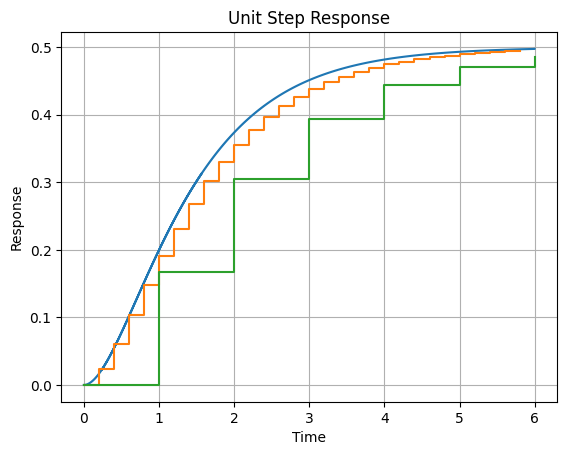

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import solve_ivp
import casadi as ca

# 定义状态空间系统的参数
A = np.array([[0, 1],
              [-2, -3]])
B = np.array([[0],
              [1]])
C = np.array([1, 0])

# 定义采样时间
Ts = 0.001 # 近似成连续系统
Ts_1 = 0.2
Ts_2 = 1

# 利用零阶保持器离散化状态空间方程
F = expm(A*Ts)
F_1 = expm(A*Ts_1)
F_2 = expm(A*Ts_2)
G = np.linalg.matrix_power(A, -1) @ (F - np.identity(F.shape[0])) @ B
G_1 = np.linalg.matrix_power(A, -1) @ (F_1 - np.identity(F_1.shape[0])) @ B
G_2 = np.linalg.matrix_power(A, -1) @ (F_2 - np.identity(F_2.shape[0])) @ B

# 打印上面四个矩阵
# print(F_1,F_2,G_1,G_2)

# 定义一个阶跃信号
def step_input(t):
    if t >= 0:
        return np.array([[1.0]])
    else:
        return 0.0

# 定义状态空间方程___nmupy数据类型
def state_space_eqn_np(x, u):
    dxdt = np.dot(A, x) + np.dot(B, u)
    return dxdt

# 定义状态空间方程___casadi数据类型
def state_space_eqn_ca(x, u):
    dxdt = A @ x + B @ u
    rhs = [dxdt[0],
           dxdt[1]]
    print(ca.vertcat(*rhs))
    return ca.vertcat(*rhs)

# Runge-Kutta order 4 离散化
def RK4_np(f, x, u, h):
    """
    Runge-Kutta 4th order solver using numpy array data type.

    Args:
        f: A function returning first order ODE in 2D numpy array (Nx x 1).
        x: Current value (list or numpy array). 
        u: System input.
        h: Step length.
    Returns:
        x_next: Vector of next value in 2D numpy array (Nx x 1)
    """
    # x = np.reshape(x, (np.shape(x)[0], -1))    # Reshape x to col vector in np 2D array
    k1 = f(x, u)
    k2 = f(x + h / 2 * k1, u)
    k3 = f(x + h / 2 * k2, u)
    k4 = f(x + h * k3, u)
    x_next = x + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next

# 隐式欧拉离散化
def Euler_np(A, B, h):
    '''
    Discrete a linear system with implicit Euler
    x[k+1] = x[k] + Δt * (A * x[k+1] + B * u[k+1])
    通常令u[k+1] = u[k], 再将x[k+1]移到左边, 得到下式
    x[k+1] = (I - delta_t * A)^{-1} @ x[k] + (I - delta_t * A)^{-1} @ (delta_t * B) @ u[k]
    '''
    Nx = np.shape(A)[0]  # A的行数=A的列数
    Ix = np.identity(Nx)
    Ak = np.linalg.inv(Ix - h * A)
    Bk = np.linalg.inv(Ix - h * A) @ (h * B)

    return Ak, Bk


# 初始化初始状态和仿真最大时间
x0 = np.array([[0], [0]])
x0_1 = np.array([[0], [0]])
x0_2 = np.array([[0], [0]])
tfinal = 6

# 初始化存储响应的列表
t_eval = []
t_eval_1 = []
t_eval_2 = []
response = []
response_1 = []
response_2 = []

'''
方法一
直接利用scipy.integrate.solve_ivp函数离散化
'''

# # 模拟连续系统的单位阶跃响应
# t_eval=np.linspace(0, tfinal, int(tfinal/Ts) + 1) # 将6s分为1000步，近似于连续
# sol = solve_ivp(state_space_eqn_np, (0, 6), x0, t_eval = t_eval) # 直接解状态空间方程
# response = np.dot(C, sol.y)


# # 模拟离散系统1的单位阶跃响应
# t_eval_1 =np.linspace(0, tfinal, int(tfinal/Ts_1) + 1) # Ts = 0.2s
# sol = solve_ivp(state_space_eqn_np, (0, 6), x0_1, t_eval = t_eval_1) # 直接解状态空间方程
# response_1 = np.dot(C, sol.y)

# # # 模拟离散系统2的单位阶跃响应
# t_eval_2 =np.linspace(0, tfinal, int(tfinal/Ts_2) + 1) # Ts = 1s
# sol = solve_ivp(state_space_eqn_np, (0, 6), x0_2, t_eval = t_eval_2) # 直接解状态空间方程
# response_2 = np.dot(C, sol.y)

'''
方法二 
利用零阶保持器推导的离散化公式
'''
# # 模拟离散系统1的单位阶跃响应
# t = 0
# while t <= tfinal:
#     t_eval.append(t)
#     response.append(C.dot(x0))
    
#     # 使用状态空间方程更新状态
#     x0 = np.dot(F, x0) + np.dot(G, step_input(t))

#     t += Ts


# # 模拟离散系统1的单位阶跃响应
# t = 0
# while t <= tfinal:
#     t_eval_1.append(t)
#     response_1.append(C.dot(x0_1))
    
#     # 使用状态空间方程更新状态
#     x0_1 = np.dot(F_1, x0_1) + np.dot(G_1, step_input(t))

#     t += Ts_1


# # 模拟离散系统2的单位阶跃响应
# t = 0
# while t <= tfinal:
#     t_eval_2.append(t)
#     response_2.append(C.dot(x0_2))
    
#     # 使用状态空间方程更新状态
#     x0_2 = np.dot(F_2, x0_2) + np.dot(G_2, step_input(t))

#     t += Ts_2


'''
方法三 
利用Kunge-Kutta order 4公式 +  numpy array 数据类型
'''
# # 模拟离散系统1的单位阶跃响应
# t = 0
# while t <= tfinal:
#     t_eval.append(t)
#     response.append(C.dot(x0))
    
#     # 使用状态空间方程更新状态
#     x0 = RK4_np(state_space_eqn_np, x0, step_input(t), Ts)
#     # print(x0)
#     t += Ts


# # 模拟离散系统1的单位阶跃响应
# t = 0
# while t <= tfinal:
#     t_eval_1.append(t)
#     response_1.append(C.dot(x0_1))
    
#     # 使用状态空间方程更新状态
#     x0_1 = RK4_np(state_space_eqn_np, x0_1, step_input(t), Ts_1)

#     t += Ts_1


# # 模拟离散系统2的单位阶跃响应
# t = 0
# while t <= tfinal:
#     t_eval_2.append(t)
#     response_2.append(C.dot(x0_2))
    
#     # 使用状态空间方程更新状态
#     x0_2 = RK4_np(state_space_eqn_np, x0_2, step_input(t), Ts_2)

#     t += Ts_2

'''
方法四 
利用Kunge-Kutta order 4公式 +  casadi 数据类型
'''
# # 构建casadi函数
# x = ca.SX.sym('x', x0.shape[0])
# u = ca.SX.sym('u', 1)
# fn_ca = ca.Function("ode_func", [x, u], [state_space_eqn_ca(x, u)])

# # 模拟离散系统1的单位阶跃响应
# t = 0
# while t <= tfinal:
#     t_eval.append(t)
#     response.append(C.dot(x0))
    
#     # 使用状态空间方程更新状态
#     x0 = RK4_np(fn_ca, x0, step_input(t), Ts)
#     t += Ts

# # 模拟离散系统1的单位阶跃响应
# t = 0
# while t <= tfinal:
#     t_eval_1.append(t)
#     response_1.append(C.dot(x0_1))
    
#     # 使用状态空间方程更新状态
#     x0_1 = RK4_np(fn_ca, x0_1, step_input(t), Ts_1)
#     t += Ts_1

# # 模拟离散系统2的单位阶跃响应
# t = 0
# while t <= tfinal:
#     t_eval_2.append(t)
#     response_2.append(C.dot(x0_2))

#     # 使用状态空间方程更新状态
#     x0_2 = RK4_np(fn_ca, x0_2, step_input(t), Ts_2)
#     t += Ts_2


'''
方法五 
利用隐式欧拉公式 +  np.array 数据类型
'''
# 求离散的A_k, B_k
A_k, B_k =Euler_np(A, B, Ts)
A_k_1, B_k_1 =Euler_np(A, B, Ts_1)
A_k_2, B_k_2 =Euler_np(A, B, Ts_2)

# 模拟离散系统1的单位阶跃响应
t = 0
while t <= tfinal:
    t_eval.append(t)
    response.append(C.dot(x0))
    
    # 使用状态空间方程更新状态
    x0 = np.dot(A_k, x0) + np.dot(B_k, step_input(t))
    t += Ts

# 模拟离散系统1的单位阶跃响应
t = 0
while t <= tfinal:
    t_eval_1.append(t)
    response_1.append(C.dot(x0_1))
    
    # 使用状态空间方程更新状态
    x0_1 = np.dot(A_k_1, x0_1) + np.dot(B_k_1, step_input(t))
    t += Ts_1

# 模拟离散系统2的单位阶跃响应
t = 0
while t <= tfinal:
    t_eval_2.append(t)
    response_2.append(C.dot(x0_2))

    # 使用状态空间方程更新状态
    x0_2 = np.dot(A_k_2, x0_2) + np.dot(B_k_2, step_input(t))
    t += Ts_2



'''
绘图
'''
# 绘制单位阶跃响应
plt.step(t_eval, response, where='post')
plt.step(t_eval_1, response_1, where='post')
plt.step(t_eval_2, response_2, where='post')
plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Unit Step Response')
plt.grid(True)
plt.show()


In [4]:
print(np.array([[1.0]]).shape)

(1, 1)


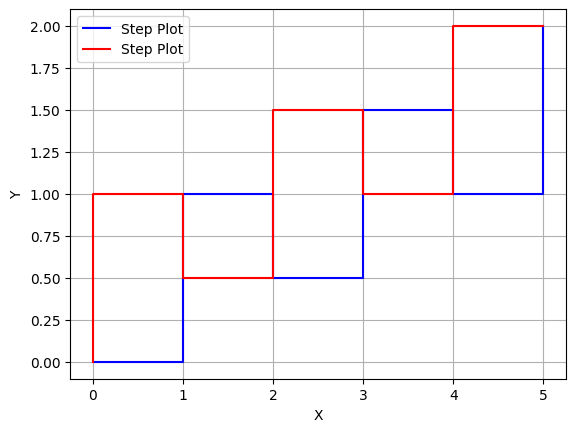

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 创建示例数据
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0, 1, 0.5, 1.5, 1, 2])

# 绘制阶梯状图
plt.step(x, y, where='post', color='b', label='Step Plot')
plt.step(x, y, where='pre', color='r', label='Step Plot')

# 配置图的标签和样式
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()
